## 1. Data loading

In [1]:
from sklearn import datasets
breast_cancer=datasets.load_breast_cancer()
x,y=breast_cancer.data,breast_cancer.target
print(x)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [5]:
n_samples, n_features = x.shape
print(n_samples)
print(n_features)

569
30


In [3]:
y.shape

(569,)

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2)

In the above code, test size denotes the fraction of data you want to use as a test dataset. So, 80% for training and 20% for testing.

## 2. Preprocessing
Since this is a classification problem, a good preprocessing step would be to apply standard scaler transformation.

In [7]:
import sklearn
scaler=sklearn.preprocessing.StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

 Pytorch works with tensors. So, we convert all four into tensors using the “torch.from_numpy()” method. It is important to convert the datatype into float32 before this. You can do that using “astype()” function.

In [8]:
import numpy as np
import torch
x_train = torch.from_numpy(x_train.astype(np.float32))
# same for x_test/y_train/y_test

But, we know that y has to be in the form of a column tensor and not a row tensor. We perform this change using the “view” operation as shown in the code. Do the same operation for y_test also.

In [9]:
y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)

ValueError: Type must be a sub-type of ndarray type

== Highlight!==
The difference between `view` and `reshape`:


torch.view has existed for a long time. It will return a tensor with the new shape. The returned tensor will share the underling data with the original tensor. See the documentation [here](https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch).

On the other hand, it seems that torch.reshape will

**Returns a tensor with the same data and number of elements as input**, but with the ~specified shape~. When possible, the returned tensor will be a view of input. Otherwise, it will be a copy. Contiguous inputs and inputs with compatible strides can be reshaped without copying, but you should not depend on the copying vs. viewing behavior.

It means that `torch.reshape` may return a copy or a view of the original tensor. You can not count on that to return a view or a copy. According to the developer:

if you need a copy use `clone()` if you need the same storage use `view()`. The semantics of `reshape()` are that it may or may not share the storage and you don't know beforehand.

Another difference is that `reshape()` can operate on both contiguous and non-contiguous tensor while `view()` can only operate on contiguous tensor. Also see here about the meaning of contiguous.


## 3. Model building

Now, we have the input data ready. We have had a glanse about build torch.nn module last week. Let’s see how to write a custom model in PyTorch for logistic regression. The first step would be to define a class with the model name. This class should derive torch.nn.Module.

Inside the class, we have the __init__ function and forward function.



In [15]:
class Logistic_Reg_model(torch.nn.Module):
 def __init__(self,no_input_features):
   super(Logistic_Reg_model,self).__init__()
   self.layer1=torch.nn.Linear(no_input_features,20)
   self.layer2=torch.nn.Linear(20,1)
 def forward(self,x):
   y_predicted=self.layer1(x)
   y_predicted=torch.sigmoid(self.layer2(y_predicted))
   return y_predicted

In the __init__ method, you have to define the layers you want in your model. Here, we use Linear layers, which can be declared from the torch.nn module. You can give any name to the layer, like “layer1” in this example. So, I have declared 2 linear layers.

The syntax is: torch.nn.Linear(in_features, out_features, bias=True)

Next, we have the “forward()” function which is responsible for performing the forward pass/propagation. The input is passed through the 2 layers defined earlier. In addition, the output from the second layer is passed through an activation function called sigmoid.

## 4. Training and optimization

In [16]:
# after define the model class, you have to initialize the model
model=Logistic_Reg_model(n_features)

Now, we need to define the loss function and optimization algorithm. Luckily in Pytorch, you can choose and import your desired loss function and optimization algorithm in simple steps. Here, we choose BCE as our loss criterion.
What is BCE loss?
- Binary Cross-Entropy loss
- Used for binary classification problem

A notable point is that, when using the BCE loss function, the output of the node should be between (0–1). We need to use an appropriate activation function for this.

For optimizer, we choose SGD or Stochastic gradient descent. I assume you are familiar with the SGD algorithm, which is commonly used as an optimizer. There are other optimizers like Adam, lars, etc. Depending upon the problem, you have to decide on the optimizer. For optimizer, you should give model parameters and learning rate as input.

> What is a learning rate?
Optimization algorithms have a parameter called the learning rate. This basically decides the rate at which the algorithm approaches the local minima, where the loss will be minimal. This value is crucial.

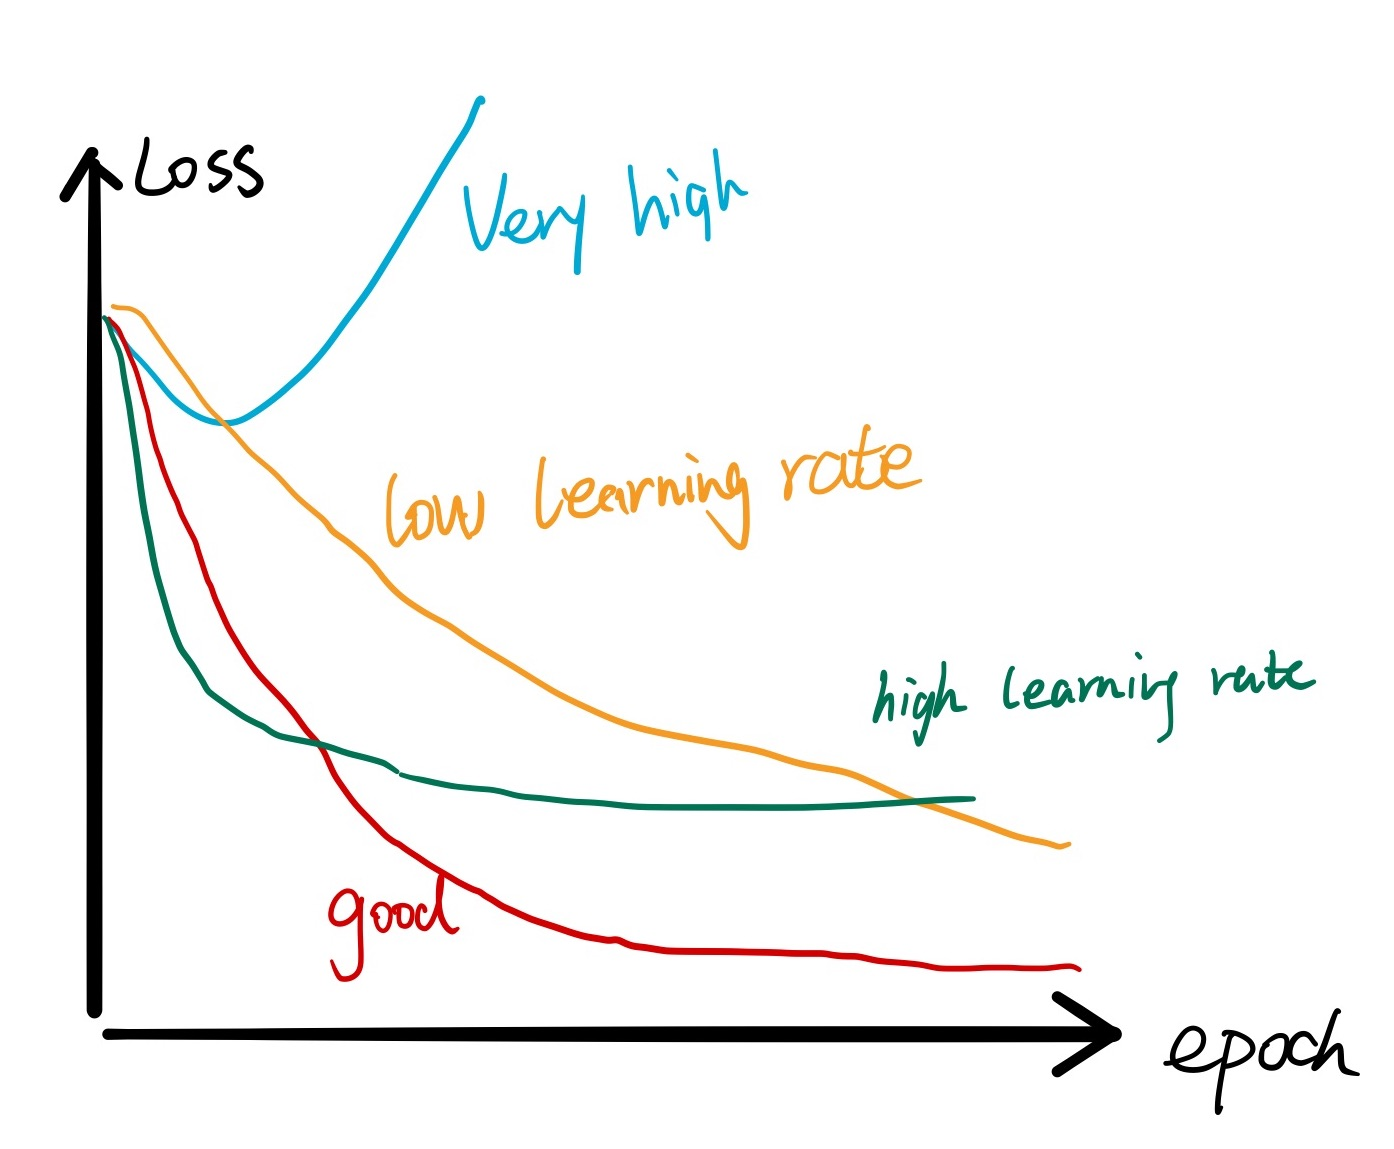

In [12]:
from IPython.display import Image
Image("flowchart5.jpg", width = 600, height = 500)

Because if the value is too high, the algorithm might shoot up and miss the local minima. On the other hand, if it’s too small, it will take a lot of time and may not converge. Hence, the Learning rate “lr” is a hyperparameter that should be fine-tuned to an optimal value.

In [18]:
criterion=torch.nn.BCELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

In [19]:
# define the train loop
number_of_epochs=100
for epoch in range(number_of_epochs):
    y_prediction=model(x_train)
    loss=criterion(y_prediction,y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%10 == 0: # it prints the loss at each 10th epoch
        print('epoch:', epoch+1,',loss=',loss.item())

TypeError: 'int' object is not callable

## 5. Calculate the accuracy
- The percentage of true predictions?
Find the code [here](https://www.analyticsvidhya.com/blog/2021/07/perform-logistic-regression-with-pytorch-seamlessly/?)